<img align="center" style='max-width: 1000px' src="images/banner.png">

<img align="left" style='max-width: 150px; height: auto' src="images/hsg_logo.png">

# Lab 02 - "Continual Learning"


## Objective

After learning the concepts in this lab, you should be able to:

- Understand how forgetting happens in non-stationary learning problems.
- Formulate an existing static problem as a continual learning problem.
- Use Avalanche to create a continual data stream from a static datasets.
- Implement new continual learning strategies with Avalanche.



## Outline


1. **Forgetting in a Simple Low-Dimensional Problem**: A visual understanding of how forgetting happens.
2. **Introduction to Avalanche**: How to create streams, run existing strategies, and implement novel strategies in Avalanche.


### Install Required Packages

In [1]:
# !pip install avalanche-lib

In [2]:
import torch
import torch.nn as nn

import tqdm
import sklearn.datasets
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")


## <font color='red'>1. Forgetting in a Simple Low-Dimensional Problem</font>



### 1.2 Dataset

For the dataset, we use the Blobs dataset from scikit-learn. Each blob is an isotropic gaussian distribution and corresponds to a class of data.

In this step, we implement a function that takes in the list of classes, and output samples of each class (blob) in the list. The function always generate the same set of blob internally, but only returns those that are in the input class list.

In [3]:
def get_blobs_dataset(classes):
    """ Creates and returns blobs datataset for a given list of classes."""
    
    # Generate Blobs
    coords, labels = sklearn.datasets.make_blobs(n_samples=500, centers=6, 
                                               n_features=2, random_state=7, 
                                               cluster_std=1.8)
    
    # Convert numpy arrays to PyTorch tensors.
    coords = torch.FloatTensor(coords)
    labels = torch.LongTensor(labels)
    
    # Placeholder for ordered tensors
    coords_ordered = []
    labels_ordered = []
    
    # Order tensors according to the given list of classes
    for c in classes:
        coords_ordered.append(coords[torch.where(labels==c)])
        labels_ordered.append(labels[torch.where(labels==c)])
    
    # Concat the class tensor lists and return them
    coords_ordered = torch.cat(coords_ordered, dim=0)
    labels_ordered = torch.cat(labels_ordered, dim=0)
    
    return coords_ordered, labels_ordered

The number of classes is fixed to 6. Let's initialize the dataset and plot it:

Text(0.5, 1.0, 'All data')

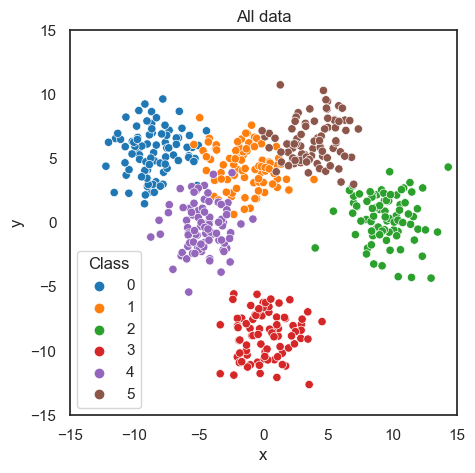

In [4]:
fig, ax = plt.subplots(figsize=(5, 5), ncols=1)

# List of all classes
all_classes = [0, 1, 2, 3, 4, 5]

# Initialize dataset
coords, labels = get_blobs_dataset(classes=all_classes)

# Plot dataset samples with Seaborn
data = {"x": coords[:, 0], "y": coords[:, 1], "Class": labels}
sns.scatterplot(data=data, x="x", y="y", hue="Class", ax=ax, hue_order=all_classes, palette="tab10")
ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15])
ax.set_title("All data")

### 1.2 Converting Static Dataset to a Data Stream

Now, we can create a dataset stream that consists of two tasks: $t_1$ and $t_2$. The first task contains classes {0, 4, 5}, and the second task contains classes {1,2,3}.

In [5]:
# All classes
all_classes = [0, 1, 2, 3, 4, 5]

# Splits for task 1 and task 2
task1_classes = [0, 4, 5]
task2_classes = [1, 2, 3]

To visualize the stream, we plot the samples from the whole dataset and samples from each task in a row:

Text(0.5, 1.0, 'Task 2')

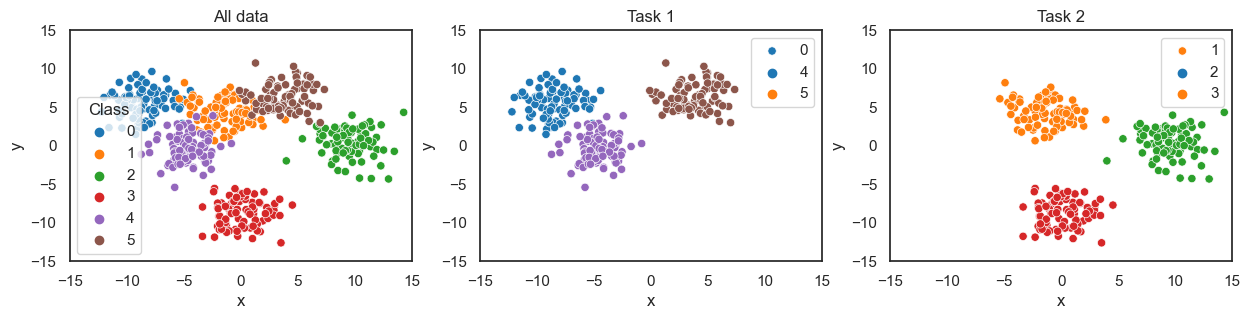

In [6]:
fig, ax = plt.subplots(figsize=(15, 3), ncols=3)

# Plot data from all classes
X, Y = get_blobs_dataset(classes=all_classes)
data = {"x": X[:, 0], "y": X[:, 1], "Class": Y}
sns.scatterplot(data=data, x="x", y="y", hue="Class", ax=ax[0], hue_order=all_classes, palette="tab10")
ax[0].set_xlim([-15, 15])
ax[0].set_ylim([-15, 15])
ax[0].set_title("All data")

# Plot Task 1 data
X, Y = get_blobs_dataset(classes=task1_classes)
data = {"x": X[:, 0], "y": X[:, 1], "Class": Y}
sns.scatterplot(data=data, x="x", y="y", hue="Class", ax=ax[1], hue_order=all_classes, palette="tab10")
ax[1].legend(task1_classes)
ax[1].set_xlim([-15, 15])
ax[1].set_ylim([-15, 15])
ax[1].set_title("Task 1")

# Plot Task 2 data
X, Y = get_blobs_dataset(classes=task2_classes)
data = {"x": X[:, 0], "y": X[:, 1], "Class": Y}
sns.scatterplot(data=data, x="x", y="y", hue="Class", ax=ax[2], hue_order=all_classes, palette="tab10")
ax[2].legend(task2_classes)
ax[2].set_xlim([-15, 15])
ax[2].set_ylim([-15, 15])
ax[2].set_title("Task 2")


### 1.3 Model Architecture

For the classification of data samples, we use a simple MLP with one hidden layer. The output size is equal to the number of classes in the dataset, which is six in our example.

In [7]:
class MLP(nn.Module):
    """ Implementation of a simple MLP with two hidden layers. """
    def __init__(self, n_classes=2):
        super().__init__()
        self.linear1 = nn.Linear(2, 10)
        self.linear2 = nn.Linear(10, n_classes)
        self.nonlin = nn.Tanh()

    def forward(self, x):
        x = self.nonlin(self.linear1(x))
        x = self.linear2(x)
        return x


### 1.4 Joint Training vs Class-Incremental Learning

The idea is to train a model in two different setting:

1. Train the model using the whole dataset
2. First train the model on task 1, and then the same model on task 2

In this step, we define a function that accepts and model and the list of classes that it should be trained with a specified number of epoch. Since a PyTorch model is passed by object reference object, the model is directly affected by the learning process.

In [8]:
def train_model(model, dataset, n_epochs=100):
    """ Trains a model for a given set of classes.
    
        classes: list of classes to use for training.
        n_epochs: number of training epochs
        model: the model to use for training.
    """    
    # Initialize criterion, optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
    
    # Initialize dataset
    coords, labels = dataset

    # Progress bar
    progress = tqdm.tqdm(list(range(n_epochs)))
    
    # Training epochs
    for epoch in progress:
        model.zero_grad()
        pred = model(coords)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        
        progress.update()
    

Once the model training is over,  we plot the decision boundary of the model on the input data with the following function:

In [9]:
def plot_decision_boundary(model, dataset, title=""):
    """ Plot model decision bounday."""
    
    # Creat meshgrid for a box range of [-15, 15] for x and y
    x_ = torch.linspace(-15, 15, 2000)
    y_ = torch.linspace(-15, 15, 2000)
    xx, yy = torch.meshgrid(x_, y_)
    
    # Compute model predicition for the meshgrid
    xx_model = torch.cat((xx.reshape(-1, 1), yy.reshape(-1, 1)), dim=1)
    zz = torch.argmax(model(xx_model), dim=1).reshape(2000, 2000)
    
    # Get data
    coords, labels = dataset
    
    data = {"x": coords[:, 0], "y": coords[:, 1], "Class": labels}
    # Set figure size
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Decision boundary (contour plot)
    ax.contourf(xx, yy, zz, cmap=plt.cm.RdYlBu, alpha=0.5)
    
    
    # Plot samples from the given list of classes
    sns.scatterplot(data=data, x="x", y="y", hue="Class",  hue_order=all_classes,  ax=ax, palette="tab10", )
#     ax.legend(classes)
    
    # Set tile
    ax.set_title(title)


#### 1.4.1 Joint Training 

In the first setting, we initialize a random model and train on the entire dataset and the plot the decision bounday of the converged model:

100%|██████████| 100/100 [00:00<00:00, 2176.65it/s]
/Users/hamed/miniconda3/envs/dl/lib/python3.9/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1680764921122/work/aten/src/ATen/native/TensorShape.cpp:3491.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


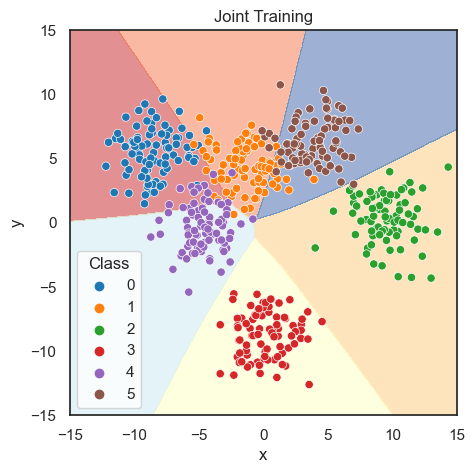

In [10]:
# Initialize model
model = MLP(n_classes=6)

# Train model on the entire dataset
dataset_all = get_blobs_dataset(classes=all_classes)
train_model(model, dataset_all, n_epochs=100)

# Plot decision boundary
plot_decision_boundary(model, dataset_all, title="Joint Training")

#### 1.4.1 Class-Incremental Learning 


In the second setting, we split the classes in the dataset between two separate tasks according to $t_1$ and $t_2$.

First, let's initialize the MLP and train on the first task and plot the decision boundary for the data samples of task 1 classes:

100%|██████████| 300/300 [00:00<00:00, 2632.84it/s]


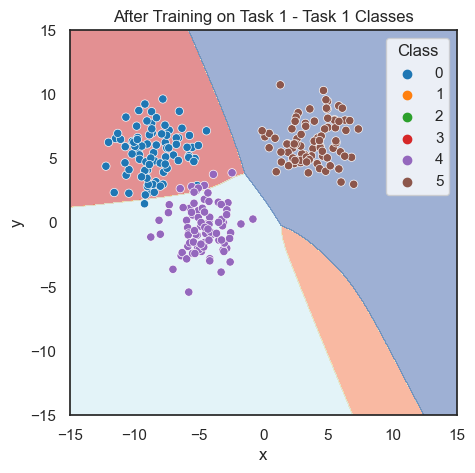

In [11]:
# Initialize model
incremental_model = MLP(n_classes=6)

# Train on the first task
dataset_t1 = get_blobs_dataset(classes=task1_classes)
train_model(incremental_model, dataset_t1, n_epochs=300)

# Plot decision boundary for task 1 classes
plot_decision_boundary(incremental_model, dataset_t1, title="After Training on Task 1 - Task 1 Classes")

Now, we take the converged model from the previous task and train on the second task. Then we plot the decision boundary of the new model on task 1 classes, task 2 classes and all classes together:

100%|██████████| 300/300 [00:00<00:00, 4018.53it/s]


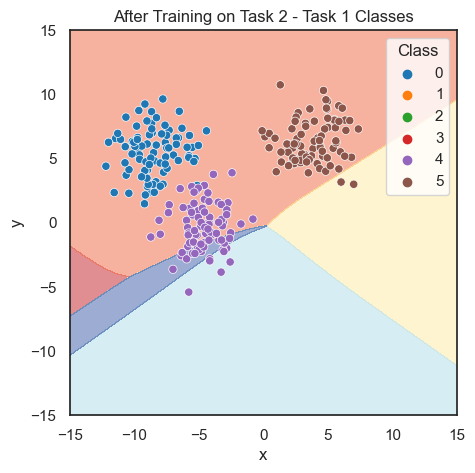

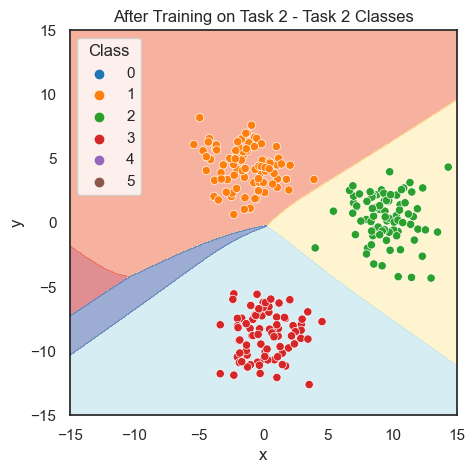

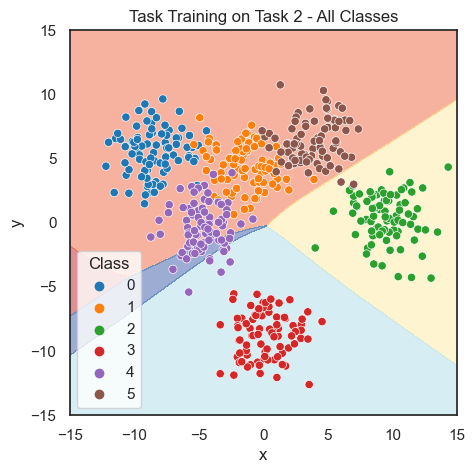

In [12]:
# Train model using previoudly train model on task 1
dataset_t2 = get_blobs_dataset(classes=task2_classes)
train_model(incremental_model, dataset_t2, n_epochs=300)

# Plot decision boundary for task 2 classes
plot_decision_boundary(incremental_model, dataset_t1, title="After Training on Task 2 - Task 1 Classes")

# Plot decision boundary for task 1 classes
plot_decision_boundary(incremental_model, dataset_t2, title="After Training on Task 2 - Task 2 Classes")

# Plot decision boundary for all classes
plot_decision_boundary(incremental_model, dataset_all, title="Task Training on Task 2 - All Classes")

We can clearly see that data from Task 1 classes are misclassified after training on Task 2. This is what we refer to as "forgetting" Task 1.

# <font color='red'>2. Introduction to Avalanche</font>


- Avalanche is an end-to-end library for continual learning.

- It is one of the open source products of Continual AI: https://www.continualai.org/


### 2.1 Library Components

The library consists of different components that can be used separately:

1. Benchmarks
2. Strategies
3. Metrics

<img align="center" width="700" src="images/avalanche.png">

Link: https://avalanche.continualai.org/


##### Data Streams in Avalanche
Data streams consist of sequence of experiences where each experience contains one dataset:

<img align="center" width="500" src="images/avalanche_stream.png">


### 2.2 Standard Benchmarks

We can easily create new benchmarks, or access standard benchmarks with the benchmark module.

Link: https://avalanche-api.continualai.org/en/v0.2.1/benchmarks.html



##### Example: Domain-Incremental

Benchmark name: Rotated MNIST

In Rotated MNIST we have all 10 classes in every experience.

<img align="center" width="600" src="images/benchmark_rotmnist.png">


In [13]:
from avalanche.benchmarks import RotatedMNIST

benchmark = RotatedMNIST(n_experiences=5, dataset_root="./data")

Once we create an instance of a benchmark, we can can access the `train_stream` and `test_stream` in the benchmark for training purposes. 

Now let's print the classes inside each experience:

In [14]:
for experience in benchmark.train_stream:
    print(f"Experience {experience.current_experience}")
    print(experience.classes_in_this_experience)
    print()

Experience 0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Experience 1
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Experience 2
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Experience 3
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Experience 4
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



Each experience contains a dataset that is a PyTorch-compatible dataset. This means that it can be used with any other PyTorch-based library. The dataset within each experience can be accessed via `experience.dataset`. 

We can also use a PyTorch dataloader to create a dataloader for the experience dataset:


In [15]:
from torch.utils.data import DataLoader

# Get the third experience in the stream
experience = benchmark.train_stream[2]

# Get access to the dataset of the third experience
ds_exp3 = experience.dataset

# Create dataloader as usual
dataloader = DataLoader(ds_exp3, batch_size=32)

##### Example: Class-Incremental

Benchmark name: Split-MNIST

In each experience, we have new set of classes.

<img align="center" width="600" src="images/benchmark_splitmnist.png">


In [16]:
from avalanche.benchmarks import SplitMNIST

benchmark = SplitMNIST(n_experiences=5, dataset_root="./data")

In [17]:
for experience in benchmark.train_stream:
    print(f"Experience {experience.current_experience}")
    print(experience.classes_in_this_experience)
    print()

Experience 0
[8, 2]

Experience 1
[3, 5]

Experience 2
[0, 6]

Experience 3
[1, 7]

Experience 4
[9, 4]



### 2.2 Creating Your Own Benchmarks

Using benchmark generators, you can create your own benchmark from an existing dataset.

Some common types of benchmarks:

- New Instances (Domain-Incremental)
- New Classes (Class-Incremental)


In [18]:
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark


We start from a standard PyTorch dataset:

In [19]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

# Dataset transformations
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Initialize PyTorch train and test sets
mnist_train = MNIST('./data/mnist', train=True, download=True, transform=train_transform)
mnist_test = MNIST('./data/mnist', train=False, download=True, transform=test_transform)

Then, we create a domain-incremental scenario using `ni_benchmark`:


In [20]:
benchmark = ni_benchmark(
    mnist_train, 
    mnist_test, 
    n_experiences=5, 
    shuffle=True, 
    seed=0, 
    balance_experiences=True
)

for experience in benchmark.train_stream:
    trainset_i = experience.dataset
    print(f"Experience {experience.current_experience} contains {len(trainset_i)} Samples")

Experience 0 contains 11998 Samples
Experience 1 contains 12002 Samples
Experience 2 contains 12000 Samples
Experience 3 contains 11999 Samples
Experience 4 contains 12001 Samples


Other types of benchmarks can be generated with:

1. `avalanche.benchmark.generators.nc_benchmark`

2. `avalanche.benchmark.generators.dataset_benchmark`

3. `avalanche.benchmark.generators.filelist_benchmark`

4. `avalanche.benchmark.generators.tensors_benchmark`

For more examples:

https://avalanche.continualai.org/from-zero-to-hero-tutorial/03_benchmarks

### 2.3 Models in Avalanche


##### Single-Head Models:

In both Class-Incremental and Domain-Incremental scenarios, usually single-head models are used. Single-head models don't require a task ID for training for inference:

<img align="center" width="300" src="images/single-head.png">


Avalanche provides a set of commonly used models for popular benchmarks such as simple CNNs and SlimResNet-18:

In [21]:
from avalanche.models import SimpleCNN, SlimResNet18

##### Multi-Head Models:

In the Task-Incremental scenario, the model requires task ID for both training for inference. In Avalanche, the head for each task can be dynamically created as a separate head:


<img align="center" width="300" src="images/multi-head.png">


Some examples of multi-head models are  MTSimpleCNN and MTSlimResNet18:

In [22]:
from avalanche.models import MTSimpleCNN, MTSlimResNet18

mt_model = MTSimpleCNN()

No need to define the number of classes, it will automatically detect the number of classes through the dataset of the current task.

### 2.4 Strategies


Strategies are algorithms that take in a model and a stream of data, and update the model according to the given stream of experiences.

First, let's initialize a Naive strategy which is the simplest type of a strategy: 

In [23]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

# Avalanche imports
from avalanche.models import SimpleMLP
from avalanche.training.supervised import Naive
from avalanche.benchmarks import SplitMNIST

# Initialize model, optimizer, criterion
model = SimpleMLP(num_classes=10)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

# Benchmark
benchmark = SplitMNIST(n_experiences=5, seed=1)

# Initialize strategy
strategy = Naive(
    model, 
    optimizer, 
    criterion,
    train_mb_size=100, 
    train_epochs=4, 
    eval_mb_size=100
)

# strategy.train(benchmark.train_stream)

At this step, we need to understand what the strategy does when we call `strategy.train(...)`


A strategy is defined, based on the concept of a template. A template provides a particular flow and structure for a training process. 

For example: the supervised continual learning template, it provides a base trainer and evaluator for a supervised classification setting. The training steps of the learning process are defined in the form of callbacks within the template.


Below, you can see the template structure for a supervised classification problem.




    1.  before_training 
    2.  before_train_dataset_adaptation
    3.  train_dataset_adaptation
    4.  after_train_dataset_adaptation
    5.  make_train_dataloader
    6.  model_adaptation
    7.  make_optimizer
    8.  before_training_exp  
    9.     before_training_epoch  
    10.       before_training_iteration
    11.            before_forward
    12.            after_forward
    13.            before_backward
    14.            after_backward
    15.            before_update
    16.            after_update
    17.       after_training_iteration
    18.     after_training_epoch
    19.  after_training_exp
    20.  after_training
  

In simple terms, the Naive strategy is the simplest form a strategy that performs SGD updates on a model for a given sequence of experiences. 

The animation below shows the example of callbacks in the EWC strategy that regularizes the training loss by penalizing weight changes according to their importance:


<img align='center' style='max-width: 900px' src='images/avalanche_template.gif'>

### 2.5 Training

Since the strategy takes care of all training steps, the main training loop in Avalanche is very simple. We just need to call `stratey.call(exp)` for each experience or just feed it with the entire stream:

In [ ]:
# Iterate over stream of experiences and call strategy.train() for each experience

results = []
acc_exp_0_naive = []
for itr, experience in enumerate(benchmark.train_stream):
    print("\n\nStart of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    
    # Train on the current experience
    strategy.train(experience)
    print('Training completed')
    
    # Test on the whole test stream
    print('Computing accuracy on the whole test set')
    res = strategy.eval(benchmark.test_stream[:itr+1])
    results.append(res)

    # Add accuracy on the first experience to the list
    acc_exp_0_naive += [res["Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000"]]

The result at each step is a dictionary. Now have a list of dictionaries, each from the test phases of the benchmark's test stream.

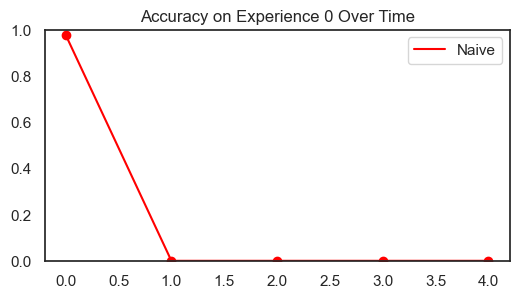

In [25]:
# Plot results with Seaborn and set y value range
plt.title("Accuracy on Experience 0 Over Time")
plt.plot(acc_exp_0_naive, label="Naive", color="red")
plt.legend()
plt.ylim([0.0, 1])
plt.gcf().set_size_inches(6, 3)
plt.scatter(range(len(acc_exp_0_naive)), acc_exp_0_naive, color="red")


### 2.6 Extending Your Strategy with a Plugin

In general, there are two ways to implement a new strategy in Avalanche:

1. Take the main template, and change its main callbacks according to add the operations needed for your new strategy.

2. Take an existing strategy, and extend it with a plugin.

A plugin, extends an existing callback in a strategy that is based on a particular training template.



##### Example: Replay Plugin


The Replay strategy, which stores a subset of samples from past experiences is a buffer for rehearsal, can be implemented as a plugin on top of the Naive strategy. Here is how we can do it:

We know that the Naive strategy only performs SGD updates to a model for a given set of experience. We can extend a Naive strategy and convert it to a Replay strategy by

1. Adding a buffer to store samples
2. Adding the replay loss at each step of training
3. Updating the buffer after each experience

All other steps remain the same!

Not all strategies can be implemented as a plugin, but if possible, implementing it as a plugin can significantly speed up the implemenetation process and avoid potential mistakes.



Since Avalanche already provides the Replay plugin, we can take it and add it to our strategy.


Below, we can see the callbacks that the replay plugin extends in the Naive Strategy:

    1.  before_training
    2.  before_train_dataset_adaptation
    3.  train_dataset_adaptation
    4.  after_train_dataset_adaptation
    5.  make_train_dataloader              -----------> Combine dataset with buffer
    6.  model_adaptation
    7.  make_optimizer
    8.  before_training_exp  
    9.     before_training_epoch  
    10.       before_training_iteration
    11.            before_forward
    12.            after_forward
    13.            before_backward
    14.            after_backward
    15.            before_update
    16.            after_update
    17.       after_training_iteration
    18.     after_training_epoch
    19.  after_training_exp                -----------> Update buffer
    20.  after_training
    

In [26]:
from avalanche.training.plugins import ReplayPlugin
from avalanche.training.storage_policy import ClassBalancedBuffer

# Define compute device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer, criterion
model = SimpleMLP(num_classes=10)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

# Define storage policy
storage_policy = ClassBalancedBuffer(max_size=500)

# Initialize replay plugin
replay_plugin = ReplayPlugin(mem_size=500, storage_policy=storage_policy)

# Initialize strategy and add the replay plugin
strategy = Naive(
    model, optimizer, criterion,
    plugins=[replay_plugin], # add plugins here as a list of plugins
    train_mb_size=32,
    train_epochs=2,
    device=device
)


The rest is the same as before. We just need to call `strategy.train()` on any experience.

In [ ]:
# Scenario
benchmark = SplitMNIST(n_experiences=5, seed=1)

# Iterate over stream experiences and call strategy.train() for every experience
results = []
acc_exp_0_replay = []
for itr, experience in enumerate(benchmark.train_stream):
    print("\n\nStart of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    
    strategy.train(experience)
    print('Training completed')
    
    print('Computing accuracy on the whole test set')
    res = strategy.eval(benchmark.test_stream[:itr+1])
    results.append(res)

    # Get accuracy on the first experience
    acc_exp_0_replay += [res["Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000"]]

Now, let's plot the accuracy on the first experience over time:

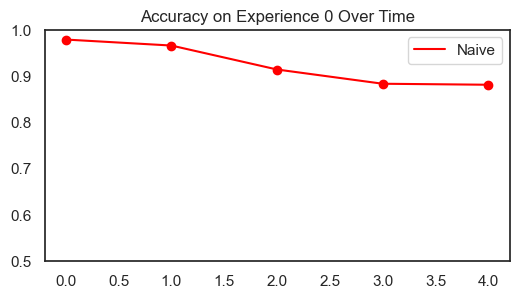

In [28]:
# Plot results with Seaborn and set y value range
plt.title("Accuracy on Experience 0 Over Time")
plt.plot(acc_exp_0_replay, label="Naive", color="red")
plt.legend()
plt.ylim([0.5, 1])
plt.gcf().set_size_inches(6, 3)
plt.scatter(range(len(acc_exp_0_replay)), acc_exp_0_replay, color="red")


##### Example: Gradient Episodic Memory (GEM) 


GEM is another popular strategy that can be implemented as aplugin. It uses *reference gradients* from previous tasks regularize model changes over time.

<img align="center" width="600" src="images/gem_alignment.png">

If the gradient from the current task does not align with one of the previous gradients, it solves a quadratic program to project the gradient onto another gradient $\tilde{g}$ that satisifies:

$minimize_{\tilde{g}} \frac{1}{2} ||g-\tilde{g}||_2^2$ <br>
subject to $\langle \tilde{g}, g_k\rangle \ge 0$ for all $k<t$





In [29]:
from avalanche.training.plugins import GEMPlugin

# Initialize model, optimizer, criterion
model = SimpleMLP(num_classes=10)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

# Initialize GEM plugin
gem_plugin = GEMPlugin(patterns_per_experience=100, memory_strength=0.5)

# Set device
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

# Initialize strategy and add the GEM plugin
strategy = Naive(
    model, optimizer, criterion,
    plugins=[gem_plugin], # Add plugins here as a list of plugins
    train_mb_size=32,
    train_epochs=2, 
    device=device
)


Now, we can train the model as before.

In [ ]:
# scenario
benchmark = SplitMNIST(n_experiences=5, seed=1)

acc_exp_0_gem = []

# Iterate over stream experiences and call strategy.train() for every experience
results = []
for itr, experience in enumerate(benchmark.train_stream):
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    
    strategy.train(experience)
    print('Training completed')
    
    print('Computing accuracy on the whole test set')
    res = strategy.eval(benchmark.test_stream[:itr+1])
    results.append(res)

    # Get accuracy on the first experience
    acc_exp_0_gem += [res["Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000"]]

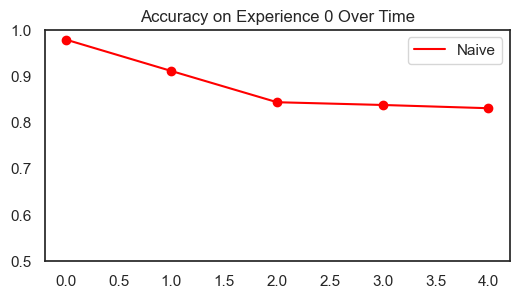

In [31]:
# Plot results with Seaborn and set y value range
plt.title("Accuracy on Experience 0 Over Time")
plt.plot(acc_exp_0_gem, label="Naive", color="red")
plt.legend()
plt.ylim([0.5, 1])
plt.gcf().set_size_inches(6, 3)
plt.scatter(range(len(acc_exp_0_gem)), acc_exp_0_gem, color="red")


##### Example: Hybrid Strategies


The term "hybrid strategy" often refers to a strategy that combines multiple objectives from other strategies. Since plugins provide an easy way to extend an existing strategy, we can add multiple of them to extend the Naive Strategy. 

For example, we can calculate the EWC and Replay loss for each training step and add it to the main loss term of the optimization process:

$L = L_{CE} + \alpha  L_{EWC} + \beta L_{Replay}$



The only thing we need to do in Avalanche, is to define a Naive strategy, and add these plugins to the strategy:

In [32]:
from avalanche.training.supervised import Naive
from avalanche.training.plugins import EWCPlugin, GEMPlugin

# Initialize model, optimizer, criterion
model = SimpleMLP(num_classes=10)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay plugin
storage_policy = ClassBalancedBuffer(max_size=500)
replay_plugin = ReplayPlugin(mem_size=500, storage_policy=storage_policy)

# EWC plugin
ewc_plugin = EWCPlugin(ewc_lambda=1.0)

# Initialize strategy and add the replay plugin and EWC plugin
strategy = Naive(
    model, optimizer, criterion,
    plugins=[replay_plugin, ewc_plugin], # Add both plugins here
    device=device,
    train_mb_size=32,
    train_epochs=2, 
)



In [ ]:
# scenario
benchmark = SplitMNIST(n_experiences=5, seed=1)

acc_exp_0_hybrid = []

# Iterate over stream experiences and call strategy.train() for every experience
results = []
for itr, experience in enumerate(benchmark.train_stream):
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    
    strategy.train(experience)
    print('Training completed')
    
    print('Computing accuracy on the whole test set')
    res = strategy.eval(benchmark.test_stream[:itr+1])
    results.append(res)

    # Get accuracy on the first experience
    acc_exp_0_hybrid += [res["Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000"]]

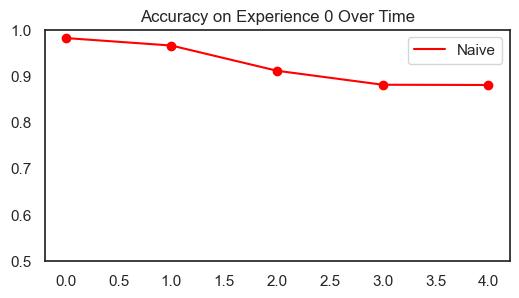

In [34]:
# Plot results with Seaborn and set y value range
plt.title("Accuracy on Experience 0 Over Time")
plt.plot(acc_exp_0_hybrid, label="Naive", color="red")
plt.legend()
plt.ylim([0.5, 1])
plt.gcf().set_size_inches(6, 3)
plt.scatter(range(len(acc_exp_0_hybrid)), acc_exp_0_hybrid, color="red")


Now, let's plot results from all strategies together and compare them:

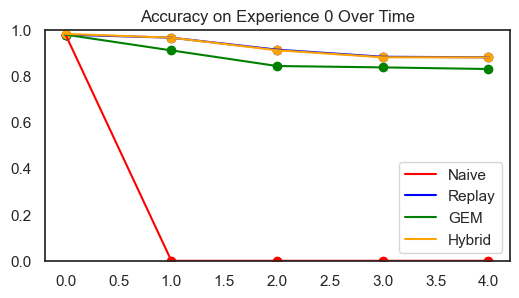

In [35]:
# Plot results from all strategies
plt.title("Accuracy on Experience 0 Over Time")
plt.plot(acc_exp_0_naive, label="Naive", color="red")
plt.plot(acc_exp_0_replay, label="Replay", color="blue")
plt.plot(acc_exp_0_gem, label="GEM", color="green")
plt.plot(acc_exp_0_hybrid, label="Hybrid", color="orange")
plt.legend()
plt.ylim([0.0, 1])
plt.gcf().set_size_inches(6, 3)
plt.scatter(range(len(acc_exp_0_naive)), acc_exp_0_naive, color="red")
plt.scatter(range(len(acc_exp_0_replay)), acc_exp_0_replay, color="blue")
plt.scatter(range(len(acc_exp_0_gem)), acc_exp_0_gem, color="green")
plt.scatter(range(len(acc_exp_0_hybrid)), acc_exp_0_hybrid, color="orange")



### 2.7 Implementing Your Own Strategy as a Plugin

If we need to design and implement a novel strategy that restricts model updates with $L1$ regularization, we can implement it as a plugin that regularizes the loss term as below:

$L = L_{CE} + \alpha |w|$ where $w$ are model weights.


    1.  before_training
    2.  before_train_dataset_adaptation
    3.  train_dataset_adaptation
    4.  after_train_dataset_adaptation
    5.  make_train_dataloader
    6.  model_adaptation
    7.  make_optimizer
    8.  before_training_exp  
    9.     before_training_epoch  
    10.       before_training_iteration
    11.            before_forward
    12.            after_forward
    13.            before_backward         -----------> Compute L1 term and add it to the strategy's loss
    14.            after_backward
    15.            before_update
    16.            after_update
    17.       after_training_iteration
    18.     after_training_epoch
    19.  after_training_exp                
    20.  after_training

We can implement this plugin by defining a class that inherits from `SupervisedPlugin` and extends `strategy.loss` with with the regularization term:

In [36]:
from avalanche.training.plugins.strategy_plugin import SupervisedPlugin


class MyRegularizer(SupervisedPlugin):
    """ Implementation of MyReularizer plugin."""
    def __init__(self, alpha=1.0):
        super().__init__()
        
        # Regularizer weight
        self.alpha = alpha

    def before_backward(self, strategy, **kwargs):
        # Add regularization loss to the strategy's loss from the second experience
        if strategy.experience.current_experience > 0:
            # Compute L1 regularization loss
            l1_loss = 0.0
            for parameter in strategy.model.parameters():
                l1_loss += torch.abs(parameter).sum()

            # Add loss to the strategy's loss
            strategy.loss += self.alpha * l1_loss
        

In [37]:
# Initialize model, optimizer, criterion
model = SimpleMLP(num_classes=10)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Add MyRegularizer plugin
my_regularizer = MyRegularizer(alpha=0.01)

strategy = Naive(
    model, optimizer, criterion,
    train_mb_size=64, train_epochs=3, eval_mb_size=64,
    device=device,
    plugins=[my_regularizer]
)


In [ ]:
# scenario
benchmark = SplitMNIST(n_experiences=5, seed=1)

acc_exp_0_myregularizer = []

# Iterate over stream experiences and call strategy.train() for every experience
results = []
for itr, experience in enumerate(benchmark.train_stream):
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    
    strategy.train(experience)
    print('Training completed')
    
    print('Computing accuracy on the whole test set')
    res = strategy.eval(benchmark.test_stream[:itr+1])
    results.append(res)

    # Get accuracy on the first experience
    acc_exp_0_myregularizer += [res["Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000"]]

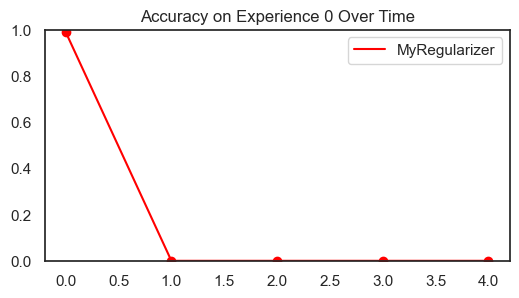

In [39]:
# Plot results with Seaborn and set y value range
plt.title("Accuracy on Experience 0 Over Time")
plt.plot(acc_exp_0_myregularizer, label="MyRegularizer", color="red")
plt.legend()
plt.ylim([0.0, 1])
plt.gcf().set_size_inches(6, 3)
plt.scatter(range(len(acc_exp_0_myregularizer)), acc_exp_0_myregularizer, color="red")


If you are interested to learn more about Avalanche, please refer to the "From Zero to Hero" tutorial seies accssible via https://avalanche.continualai.org/from-zero-to-hero-tutorial/01_introduction